In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import spacy

In [2]:
df = pd.read_csv("diario_emociones.csv")

# Balancear clases por sobremuestreo
dfs = []
for emocion in df["emocion"].unique():
    subset = df[df["emocion"] == emocion]
    dfs.append(resample(subset, 
                      replace=True, 
                      n_samples=500,  # Ajustar según necesidad
                      random_state=42))
df = pd.concat(dfs, ignore_index=True)

In [3]:
nlp = spacy.load("es_core_news_sm")

def limpiar_texto(texto):
    doc = nlp(texto.lower())
    tokens = [
        token.lemma_ 
        for token in doc 
        if not token.is_stop 
        and not token.is_punct
        and token.is_alpha
    ]
    return " ".join(tokens)

df["texto_limpio"] = df["texto"].apply(limpiar_texto)

In [4]:
vectorizer = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 2),  # Bigramas
    min_df=5,            # Ignorar términos raros
    max_df=0.9          # Ignorar términos muy comunes
)
X = vectorizer.fit_transform(df["texto_limpio"]).toarray()

# Codificación de emociones
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["emocion"])



In [5]:
model = Sequential()
model.add(Dense(
    256, 
    input_shape=(X.shape[1],),
    activation='relu',
    kernel_regularizer=l2(0.02),
    activity_regularizer=l2(0.01)
))
model.add(Dropout(0.7))
model.add(Dense(
    128,
    activation='relu',
    kernel_regularizer=l2(0.01))
)
model.add(Dropout(0.6))
model.add(Dense(
    len(label_encoder.classes_), 
    activation='softmax'
))

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


C:\Users\walte\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.2576 - loss: 8.0193 - val_accuracy: 0.7820 - val_loss: 4.5361
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4535 - loss: 3.9032 - val_accuracy: 0.6800 - val_loss: 2.5523
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4601 - loss: 2.3300 - val_accuracy: 0.9760 - val_loss: 1.8605
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6914 - loss: 1.7798 - val_accuracy: 1.0000 - val_loss: 1.5483
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8417 - loss: 1.4897 - val_accuracy: 1.0000 - val_loss: 1.2011
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9451 - loss: 1.1913 - val_accuracy: 1.0000 - val_loss: 0.8861
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9800 - loss: 0.9795 - val_accuracy: 1.0000 - val_loss: 0.7474
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9836 - loss: 0.8639 - val_accuracy: 1.0000 - 

In [7]:
def predecir_emocion(texto, umbral_confianza=0.65):
    texto_limpio = limpiar_texto(texto)
    texto_vector = vectorizer.transform([texto_limpio]).toarray()
    prediccion = model.predict(texto_vector, verbose=0)
    
    if np.max(prediccion) < umbral_confianza:
        return "indefinido", np.max(prediccion)
    
    return label_encoder.inverse_transform([np.argmax(prediccion)])[0], np.max(prediccion)

In [8]:
def chatbot_respuesta(texto):
    emocion, confianza = predecir_emocion(texto)
    
    recursos = {
        "tristeza": {
            "mensaje": "🔵 Pareces sentir tristeza. Te recomiendo:",
            "acciones": [
                "Meditación guiada 'Alivio emocional' (10 min)",
                "Ejercicio: Escribe una carta para liberar emociones"
            ]
        },
        "ansiedad": {
            "mensaje": "🟠 Detecto señales de ansiedad. Prueba:",
            "acciones": [
                "Técnica de respiración 4-7-8 (instrucciones)",
                "Ejercicio de grounding: 5-4-3-2-1"
            ]
        },
        "estrés": {
            "mensaje": "🟢 Sugerencias para manejar el estrés:",
            "acciones": [
                "Meditación 'Libera tensiones' (15 min)",
                "Prioriza tareas con matriz Eisenhower"
            ]
        },
        "enojo": {
            "mensaje": "🔴 Detecto frustración. Intenta:",
            "acciones": [
                "Ejercicio físico de alta intensidad",
                "Técnica de pausa consciente de 5 minutos"
            ]
        },
        "felicidad": {
            "mensaje": "🟡 ¡Me alegra verte así! Mantén esto:",
            "acciones": [
                "Registra este momento en tu diario positivo",
                "Comparte tu estado con alguien especial"
            ]
        },
        "indefinido": {
            "mensaje": "⚪️ Necesito entenderte mejor. ¿Podrías:",
            "acciones": [
                "Describir cómo te sientes con más detalle?",
                "Contarme qué ha pasado recientemente?"
            ]
        }
    }
    
    respuesta = recursos.get(emocion, recursos["indefinido"])
    return (
        f"{respuesta['mensaje']}\n" + 
        "\n".join([f"- {accion}" for accion in respuesta['acciones']]) + 
        f"\n\nConfianza del modelo: {confianza:.2%}"
    )


In [9]:
test_cases = [
    "No tengo ganas de salir de la cama hoy",
    "Estoy harto de las reuniones inútiles",
    "Me palpita el corazón muy rápido",
    "Logré terminar todos mis pendientes a tiempo!",
    "El tráfico me hizo llegar tarde otra vez"
]

for caso in test_cases:
    print(f"🧑 Usuario: {caso}")
    print(f"🤖 Chatbot:\n{chatbot_respuesta(caso)}\n")
    print("―" * 50)

🧑 Usuario: No tengo ganas de salir de la cama hoy
🤖 Chatbot:
🟠 Detecto señales de ansiedad. Prueba:
- Técnica de respiración 4-7-8 (instrucciones)
- Ejercicio de grounding: 5-4-3-2-1

Confianza del modelo: 70.07%

――――――――――――――――――――――――――――――――――――――――――――――――――
🧑 Usuario: Estoy harto de las reuniones inútiles
🤖 Chatbot:
🔴 Detecto frustración. Intenta:
- Ejercicio físico de alta intensidad
- Técnica de pausa consciente de 5 minutos

Confianza del modelo: 76.42%

――――――――――――――――――――――――――――――――――――――――――――――――――
🧑 Usuario: Me palpita el corazón muy rápido
🤖 Chatbot:
⚪️ Necesito entenderte mejor. ¿Podrías:
- Describir cómo te sientes con más detalle?
- Contarme qué ha pasado recientemente?

Confianza del modelo: 34.15%

――――――――――――――――――――――――――――――――――――――――――――――――――
🧑 Usuario: Logré terminar todos mis pendientes a tiempo!
🤖 Chatbot:
⚪️ Necesito entenderte mejor. ¿Podrías:
- Describir cómo te sientes con más detalle?
- Contarme qué ha pasado recientemente?

Confianza del modelo: 57

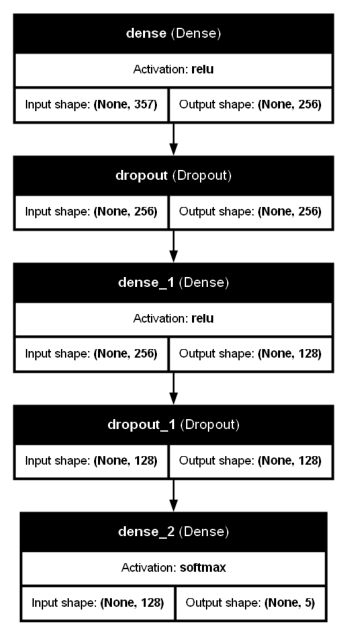

In [16]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'  # Ajusta la ruta si instalaste en otra ubicación

plt.figure(figsize=(12, 8))
plot_model(
    model,
    to_file='model_plot.png',
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=96
)
plt.imshow(plt.imread('model_plot.png'))
plt.axis('off')
plt.show()

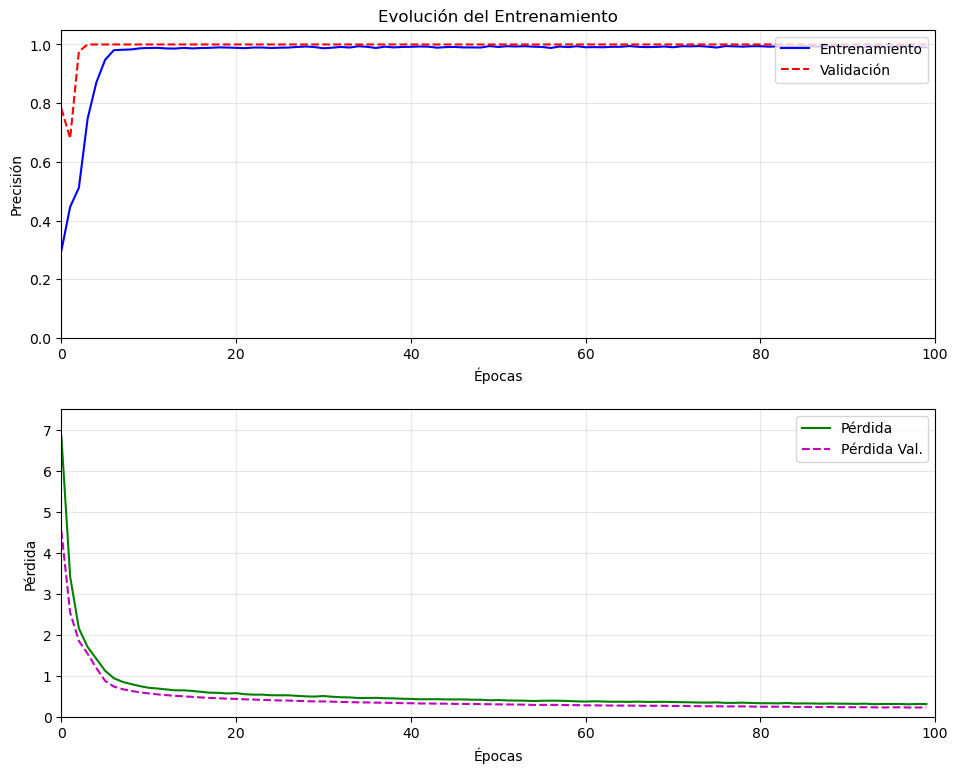

In [20]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np

# Configurar figura
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plt.tight_layout(pad=3.0)

# Inicializar líneas
line1, = ax1.plot([], [], 'b-', label='Entrenamiento')
line2, = ax1.plot([], [], 'r--', label='Validación')
line3, = ax2.plot([], [], 'g-', label='Pérdida')
line4, = ax2.plot([], [], 'm--', label='Pérdida Val.')

# Configuraciones de ejes
for ax in [ax1, ax2]:
    ax.set_xlabel('Épocas', fontsize=10)
    ax.legend(loc='upper right')
    ax.grid(alpha=0.3)
    
ax1.set_ylabel('Precisión', fontsize=10)
ax2.set_ylabel('Pérdida', fontsize=10)
ax1.set_title('Evolución del Entrenamiento', fontsize=12)

# Datos iniciales
def init():
    for line in [line1, line2, line3, line4]:
        line.set_data([], [])
    return line1, line2, line3, line4

# Función de actualización
def animate(i):
    x = np.arange(i+1)
    
    line1.set_data(x, history.history['accuracy'][:i+1])
    line2.set_data(x, history.history['val_accuracy'][:i+1])
    line3.set_data(x, history.history['loss'][:i+1])
    line4.set_data(x, history.history['val_loss'][:i+1])
    
    ax1.set_xlim(0, len(history.history['accuracy']))
    ax1.set_ylim(0, 1.05)
    ax2.set_xlim(0, len(history.history['accuracy']))
    ax2.set_ylim(0, max(history.history['loss']) * 1.1)
    
    return line1, line2, line3, line4

# Crear animación
anim = FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=len(history.history['accuracy']),
    interval=400,
    blit=True
)

# Mostrar en Jupyter
HTML(anim.to_html5_video())

In [32]:
def visualize_activations(texto):
    texto_limpio = limpiar_texto(texto)
    texto_vector = vectorizer.transform([texto_limpio]).toarray()
    
    # Obtener predicción y confianza
    emocion, confianza = predecir_emocion(texto)
    
    # Crear modelo de activaciones
    if not model.built:
        model.build(input_shape=(None, X.shape[1]))
    
    layer_outputs = [layer.output for layer in model.layers if 'dropout' not in layer.name.lower()]
    activation_model = tf.keras.Model(inputs=model.layers[0].input, outputs=layer_outputs)
    activations = activation_model.predict(texto_vector)
    
    # Configurar figura
    fig = plt.figure(figsize=(16, 8), dpi=100)
    gs = fig.add_gridspec(2, len(activations)+1, height_ratios=[3, 1])
    
    # 1. Visualización de Activaciones
    for i, (activation, layer) in enumerate(zip(activations, model.layers)):
        if 'dropout' in layer.name.lower():
            continue
            
        ax = fig.add_subplot(gs[0, i])
        ax.set_title(f'{layer.name.upper()}\n({activation.shape[1]} neuronas)', fontsize=10, pad=15)
        
        # Normalizar activaciones para mejor visualización
        norm_activation = (activation - activation.min()) / (activation.max() - activation.min())
        im = ax.imshow(norm_activation[0:1, :], cmap='plasma', aspect='auto', vmin=0, vmax=1)
        
        plt.colorbar(im, ax=ax, shrink=0.8, label='Activación normalizada')
        ax.set_xlabel('Neuronas')
        ax.set_yticks([])
        
        # Destacar neuronas más activas
        max_neuron = np.argmax(activation)
        ax.annotate('★', xy=(max_neuron, 0.5), color='gold', fontsize=14, ha='center')

    # 2. Visualización del Texto de Entrada
    ax_text = fig.add_subplot(gs[0, -1])
    ax_text.set_title('REPRESENTACIÓN DEL TEXTO', fontsize=10)
    ax_text.imshow(texto_vector, cmap='Blues', aspect='auto')
    ax_text.set_ylabel('TF-IDF Features')
    ax_text.set_xlabel('Dimensión')
    ax_text.set_xticks([])
    ax_text.set_yticks([])
    
    # 3. Explicación de la Arquitectura
    ax_info = fig.add_subplot(gs[1, :])
    ax_info.axis('off')
    info_text = (
        f"Predicción: {emocion.upper()} (Confianza: {confianza:.1%})\n"
        "Leyenda:\n"
        "• Cada columna representa una capa de la red\n"
        "★ Neurona con mayor activación en cada capa\n"
        "Color: Intensidad de activación (0: mínima, 1: máxima)\n"
        "TF-IDF: Representación numérica del texto de entrada"
    )
    ax_info.text(0.05, 0.5, info_text, ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    fig.suptitle(f'ANÁLISIS DE ACTIVACIONES NEURONALES - "{texto[:30]}..."', fontsize=12, y=0.98)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


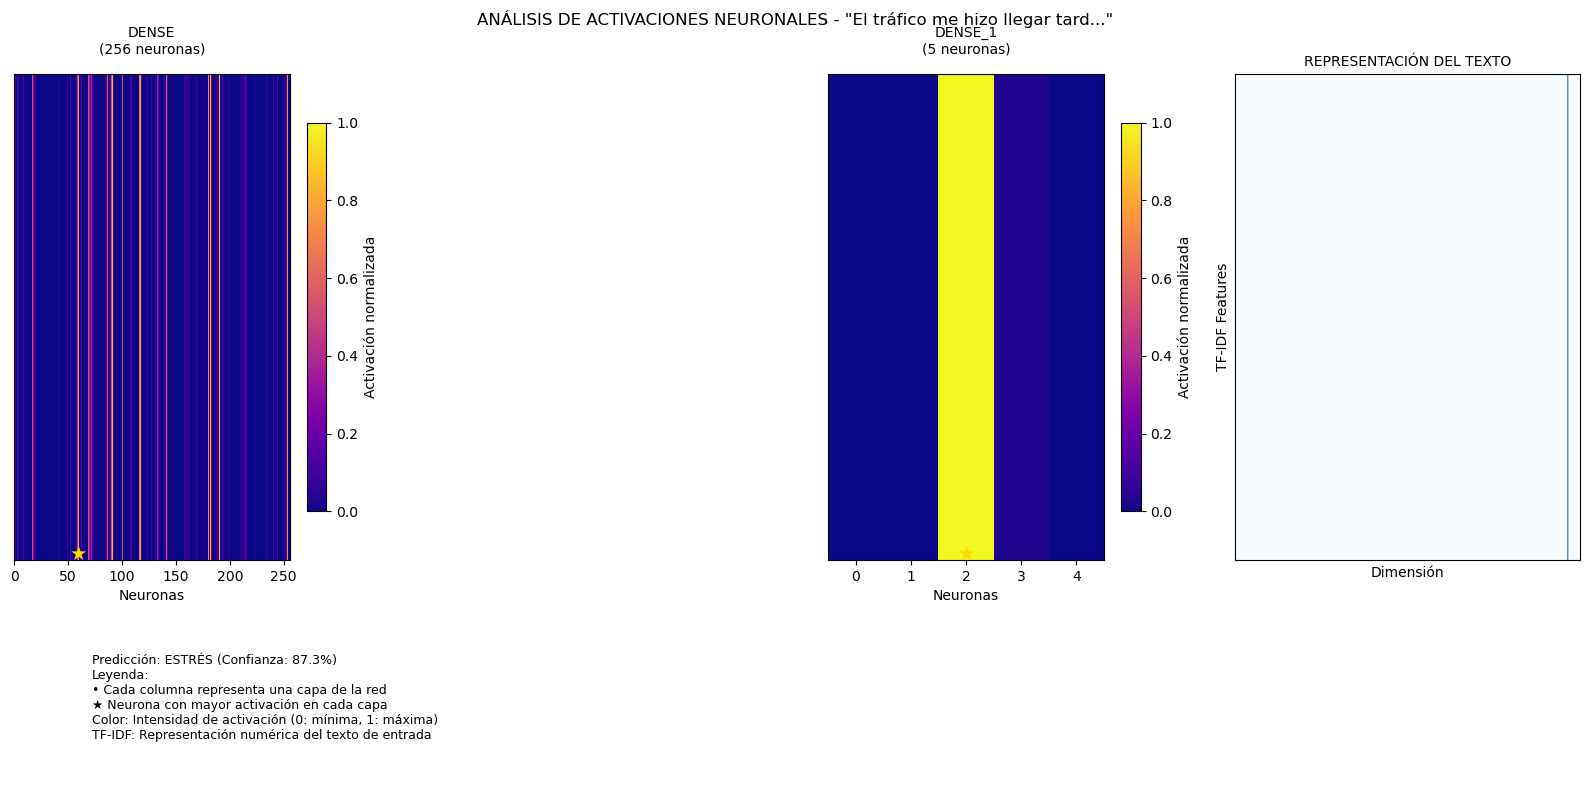

In [34]:

# Ejemplo de uso
visualize_activations("El tráfico me hizo llegar tarde otra vez")